# Linformer: Self-Attention with Linear Complexity


## Introduction to Linformer

Linformer, introduced by Wang et al. in 2020, is an efficient variant of the attention mechanism. It addresses the quadratic complexity problem of standard attention by using a low-rank approximation of the attention matrix.
 
The key idea is to project the Keys and Values to a lower-dimensional space before computing attention, reducing the complexity from O(n^2) to O(n), where n is the sequence length.


In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

torch.manual_seed(42)

# Our example phrase
phrase = "The quick brown fox jumps over the lazy dog"
words = phrase.split()
sequence_length = len(words)

# Hyperparameters
batch_size = 1
embedding_dim = 8
num_heads = 2
head_dim = embedding_dim // num_heads
k = 3  # Projection dimension for Linformer

# Create a simple embedding for our words
word_to_idx = {word: idx for idx, word in enumerate(words)}
embeddings = torch.randn(len(words), embedding_dim)

# Input
X = embeddings.unsqueeze(0)  # Add batch dimension
print("Input shape:", X.shape)

# Weight matrices
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)
W_o = torch.randn(embedding_dim, embedding_dim)

Input shape: torch.Size([1, 9, 8])


## Linformer Projection Matrices
 
The core of Linformer's efficiency comes from two projection matrices: E_proj and F_proj. These matrices project the Keys and Values to a lower-dimensional space, respectively.
 
- E_proj projects the Keys
- F_proj projects the Values
 
Both matrices have shape (num_heads, k, sequence_length), where k is the projection dimension, typically much smaller than the sequence length.
 This is where Linformer diverges from standard attention. We apply the E_proj and F_proj matrices to K and V respectively, reducing their sequence length dimension from sequence_length to k.


In [67]:
# Linformer projection matrices
E_proj = torch.randn(num_heads, k, sequence_length)
F_proj = torch.randn(num_heads, k, sequence_length)  # Renamed from F to F_proj
print("E_proj shape:", E_proj.shape)
print("F_proj shape:", F_proj.shape)


E_proj shape: torch.Size([2, 3, 9])
F_proj shape: torch.Size([2, 3, 9])


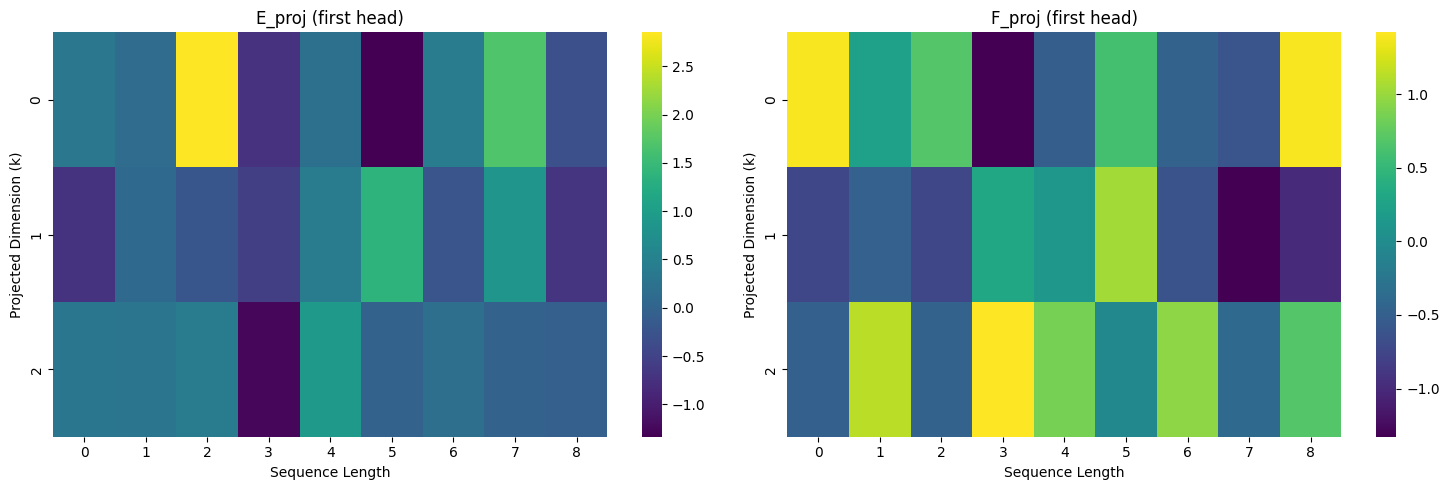

In [68]:
# Visualization of projection matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(E_proj[0], ax=ax1, cmap="viridis")
ax1.set_title("E_proj (first head)")
ax1.set_xlabel("Sequence Length")
ax1.set_ylabel("Projected Dimension (k)")
sns.heatmap(F_proj[0], ax=ax2, cmap="viridis")
ax2.set_title("F_proj (first head)")
ax2.set_xlabel("Sequence Length")
ax2.set_ylabel("Projected Dimension (k)")
plt.tight_layout()
plt.show()

## Compute Q, K, V and Reshape for Multi-head Attention
 
Similar to standard attention, we compute Q, K, and V matrices and reshape them for multi-head attention. This part is identical to the standard attention mechanism.


In [69]:
# Calculate Q, K, V matrices
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

# Reshape Q, K, V for multi-head attention
Q = Q.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)

print("Q shape after reshape:", Q.shape)
print("K shape after reshape:", K.shape)
print("V shape after reshape:", V.shape)


Q shape after reshape: torch.Size([1, 2, 9, 4])
K shape after reshape: torch.Size([1, 2, 9, 4])
V shape after reshape: torch.Size([1, 2, 9, 4])


## Apply Linformer Projections

This is where Linformer diverges from standard attention. We apply the E_proj and F_proj matrices to K and V respectively, reducing their sequence length dimension from sequence_length to k.


In [70]:
# Apply Linformer projections to K and V
K_projected = torch.matmul(E_proj.unsqueeze(0), K)
V_projected = torch.matmul(F_proj.unsqueeze(0), V)

print("K_projected shape:", K_projected.shape)
print("V_projected shape:", V_projected.shape)

K_projected shape: torch.Size([1, 2, 3, 4])
V_projected shape: torch.Size([1, 2, 3, 4])


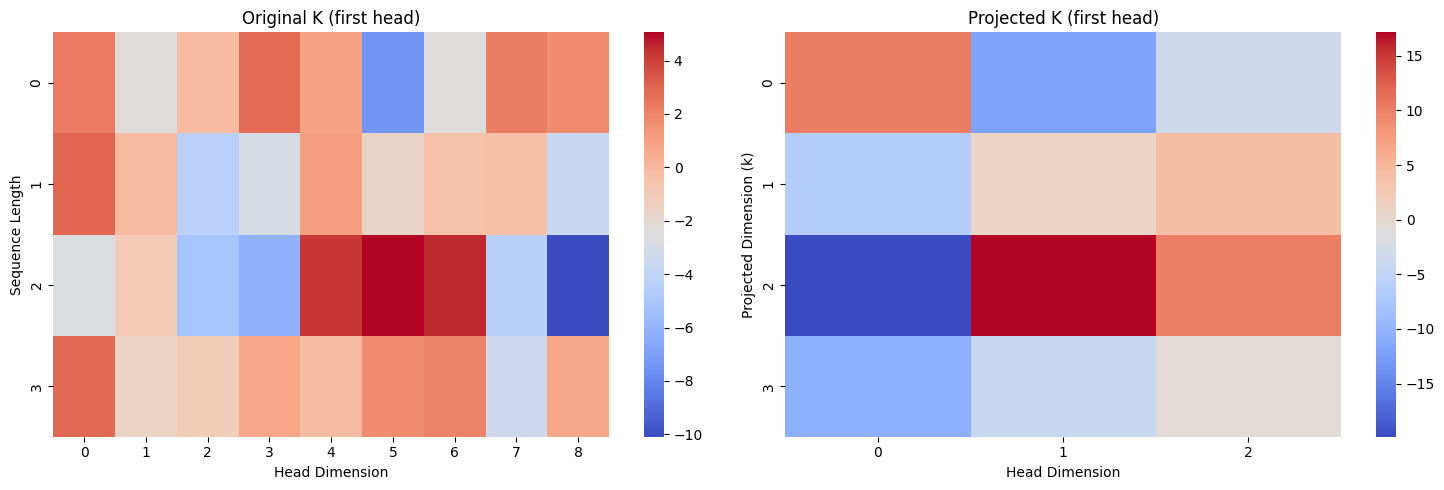

In [71]:
# Visualize the projection effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(K[0, 0].t(), ax=ax1, cmap="coolwarm")
ax1.set_title("Original K (first head)")
ax1.set_xlabel("Head Dimension")
ax1.set_ylabel("Sequence Length")
sns.heatmap(K_projected[0, 0].t(), ax=ax2, cmap="coolwarm")
ax2.set_title("Projected K (first head)")
ax2.set_xlabel("Head Dimension")
ax2.set_ylabel("Projected Dimension (k)")
plt.tight_layout()
plt.show()

## Compute Attention Scores

We compute attention scores similarly to standard attention, but using the projected K. This results in scores of shape [batch_size, num_heads, sequence_length, k] instead of [batch_size, num_heads, sequence_length, sequence_length] in standard attention.


In [72]:
# Calculate attention scores
scores = torch.matmul(Q, K_projected.transpose(-2, -1)) / (head_dim ** 0.5)

print("Attention scores shape:", scores.shape)
print("Attention scores:\n", scores)


Attention scores shape: torch.Size([1, 2, 9, 3])
Attention scores:
 tensor([[[[-25.4180,   6.0146,  11.5523],
          [  3.0190,   2.6037,   5.8395],
          [ 40.7109, -42.8422, -25.7728],
          [-15.8000,   3.2550,   3.5101],
          [-31.6846,  28.2424,  12.4101],
          [-10.3995,  22.3455,  13.1668],
          [ -5.9875,  15.0790,   5.3597],
          [ 24.4601, -20.8983, -11.1395],
          [ 47.6751, -46.4148, -25.6377]],

         [[-19.9619,  27.8070, -39.6531],
          [-10.4208,  13.9545, -18.5104],
          [  1.2550,  22.6858, -17.2082],
          [ 10.3723,  20.3871,  -8.6209],
          [ 15.2749, -31.9832,  36.3721],
          [  1.1559,   4.3175,   2.9827],
          [  7.9062, -12.4228,  20.7523],
          [ -3.7663,   4.6992,  -9.7101],
          [  2.1161,  39.4744, -21.6523]]]])


## Apply Softmax to Get Attention Weights

We apply softmax to the scores to get the attention weights. This step is identical to standard attention, but operates on the reduced dimension.


In [73]:
# Apply softmax to get attention weights
attn_weights = F.softmax(scores, dim=-1)

print("Attention weights shape:", attn_weights.shape)
print("Attention weights:\n", attn_weights)

Attention weights shape: torch.Size([1, 2, 9, 3])
Attention weights:
 tensor([[[[8.7560e-17, 3.9201e-03, 9.9608e-01],
          [5.4214e-02, 3.5791e-02, 9.0999e-01],
          [1.0000e+00, 5.1681e-37, 1.3380e-29],
          [2.3152e-09, 4.3656e-01, 5.6344e-01],
          [9.4193e-27, 1.0000e+00, 1.3308e-07],
          [6.0111e-15, 9.9990e-01, 1.0319e-04],
          [7.0943e-10, 9.9994e-01, 6.0109e-05],
          [1.0000e+00, 2.0002e-20, 3.4617e-16],
          [1.0000e+00, 1.3719e-41, 1.4477e-32]],

         [[1.7955e-21, 1.0000e+00, 5.0401e-30],
          [2.5938e-11, 1.0000e+00, 7.9557e-15],
          [4.9289e-10, 1.0000e+00, 4.7234e-18],
          [4.4734e-05, 9.9996e-01, 2.5233e-13],
          [6.8803e-10, 2.0591e-30, 1.0000e+00],
          [3.2442e-02, 7.6595e-01, 2.0160e-01],
          [2.6366e-06, 3.9108e-15, 1.0000e+00],
          [2.1057e-04, 9.9979e-01, 5.5213e-07],
          [5.9629e-17, 1.0000e+00, 2.8377e-27]]]])


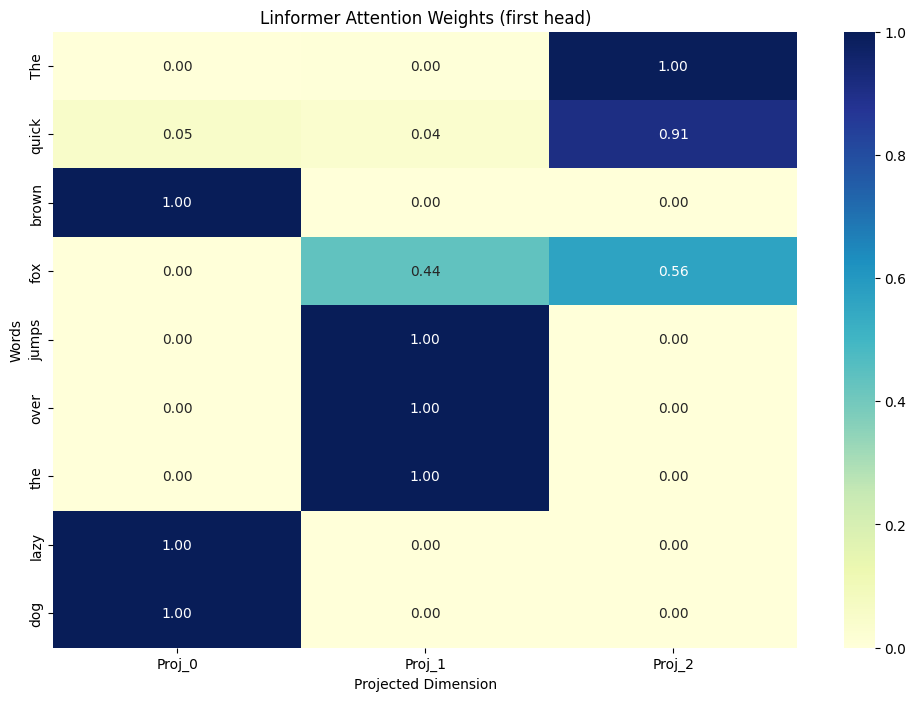

In [74]:
plt.figure(figsize=(12, 8))
sns.heatmap(attn_weights[0, 0].detach().numpy(), cmap="YlGnBu", annot=True, fmt=".2f",
            xticklabels=[f'Proj_{i}' for i in range(k)],
            yticklabels=words)
plt.title("Linformer Attention Weights (first head)")
plt.xlabel("Projected Dimension")
plt.ylabel("Words")
plt.show()

## Compute Attention Output

We apply the attention weights to the projected Values. This step is similar to standard attention, but uses the projected V of lower dimension.


In [75]:
# Apply attention weights to projected values
attn_output = torch.matmul(attn_weights, V_projected)

print("Attention output shape:", attn_output.shape)
print("Attention output:\n", attn_output)

Attention output shape: torch.Size([1, 2, 9, 4])
Attention output:
 tensor([[[[-11.4582,  -1.7028,  -4.2783,   6.6553],
          [ -9.8817,  -1.8580,  -4.3030,   5.4702],
          [ 14.4924, -12.2620,  -4.3197, -11.2316],
          [ -9.1706,   3.9243,  -4.5815,   3.7502],
          [ -6.1912,  11.2529,  -4.9764,  -0.0332],
          [ -6.1918,  11.2515,  -4.9764,  -0.0325],
          [ -6.1915,  11.2521,  -4.9764,  -0.0328],
          [ 14.4924, -12.2620,  -4.3197, -11.2316],
          [ 14.4924, -12.2620,  -4.3197, -11.2316]],

         [[  4.7930,   8.4122,  -2.6583,   2.4628],
          [  4.7930,   8.4122,  -2.6583,   2.4628],
          [  4.7930,   8.4122,  -2.6583,   2.4628],
          [  4.7929,   8.4116,  -2.6581,   2.4626],
          [ 10.5707,   0.7154, -13.7807,  -0.8778],
          [  5.8657,   6.4453,  -4.7748,   1.6637],
          [ 10.5707,   0.7154, -13.7807,  -0.8778],
          [  4.7924,   8.4095,  -2.6575,   2.4620],
          [  4.7930,   8.4122,  -2.6583,   2.4

## Reshape and Project Output
 
Finally, we reshape the attention output and apply the output projection. This step is identical to standard attention.


In [76]:
# Reshape and project output
attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, embedding_dim)
output = torch.matmul(attn_output, W_o)

print("Final output shape:", output.shape)
print("Final output:\n", output)

Final output shape: torch.Size([1, 9, 8])
Final output:
 tensor([[[ -3.7600,  -1.8296,  15.6515,  -7.8081,  19.8356,  21.2454,  10.5175,
           -6.1714],
         [ -2.7470,  -2.1911,  12.9528,  -7.4538,  19.8035,  22.9923,  10.6122,
           -5.0604],
         [ 17.5154, -10.8328, -30.5785,  -9.1628,  18.8259,  48.6203,  13.7415,
           -6.5397],
         [ -5.6542,  -0.1228,  13.0569,  -2.0395,  20.1397,  24.7879,   9.4366,
            9.0784],
         [ -4.7737,  -8.2952,  31.7480,  29.0477,  16.5733,  32.7625,  -1.3994,
           30.2899],
         [ -7.6719,  -0.1556,  14.5088,  10.5919,  18.8689,  29.0023,   5.5077,
           29.0994],
         [ -4.7735,  -8.2954,  31.7483,  29.0469,  16.5732,  32.7619,  -1.3993,
           30.2878],
         [ 17.5140, -10.8338, -30.5760,  -9.1604,  18.8203,  48.6133,  13.7375,
           -6.5404],
         [ 17.5154, -10.8328, -30.5785,  -9.1628,  18.8259,  48.6203,  13.7415,
           -6.5397]]])


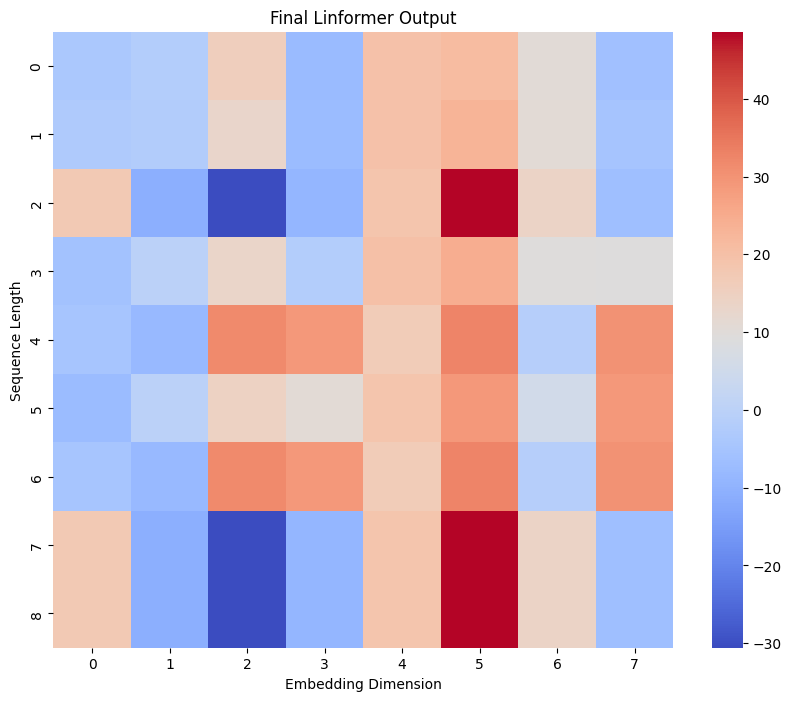

In [77]:
# Visualize final output
plt.figure(figsize=(10, 8))
sns.heatmap(output[0], cmap="coolwarm")
plt.title("Final Linformer Output")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence Length")
plt.show()

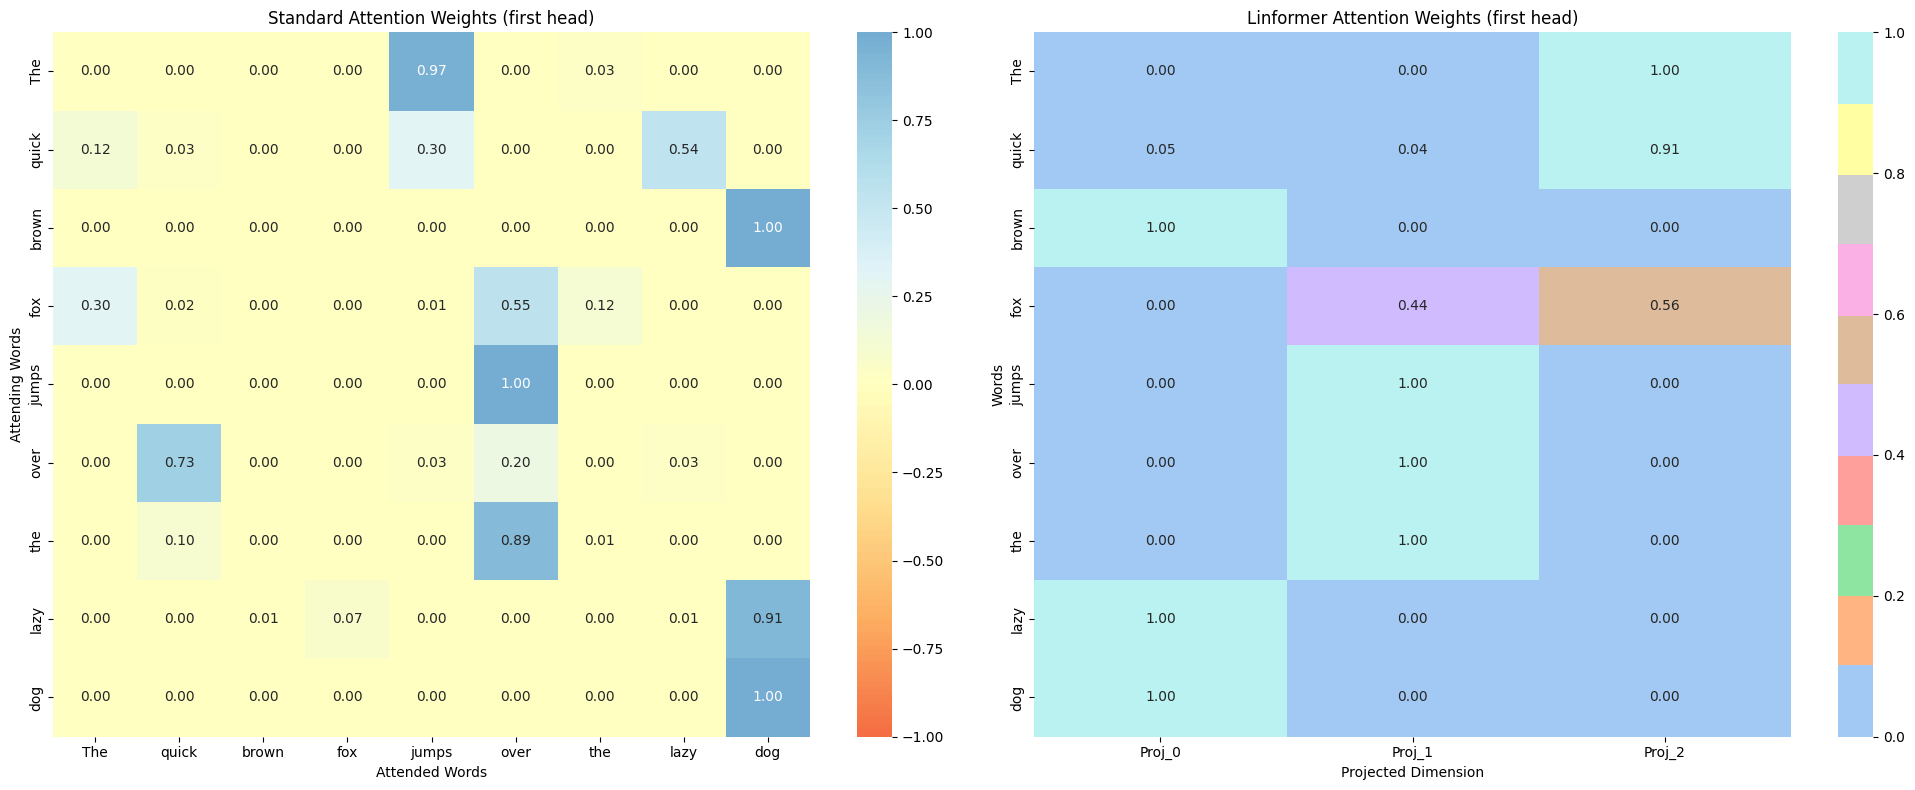

In [79]:
def standard_attention(Q, K, V):
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
    attn_weights = F.softmax(scores, dim=-1)
    return attn_weights, torch.matmul(attn_weights, V)

# Compute standard attention weights
std_attn_weights, _ = standard_attention(Q, K, V)

# Create pastel RdYlBu colormap
rdylbu = plt.cm.RdYlBu
pastel_rdylbu = LinearSegmentedColormap.from_list("pastel_rdylbu", rdylbu(np.linspace(0.2, 0.8, 256)))

# Create pastel colormap for Linformer
pastel = sns.color_palette("pastel", as_cmap=True)

# Visualize standard vs Linformer attention weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(std_attn_weights[0, 0].detach().numpy(), ax=ax1, cmap=pastel_rdylbu,
            annot=True, fmt=".2f", center=0, vmin=-1, vmax=1,
            xticklabels=words, yticklabels=words)
ax1.set_title("Standard Attention Weights (first head)")
ax1.set_xlabel("Attended Words")
ax1.set_ylabel("Attending Words")

sns.heatmap(attn_weights[0, 0].detach().numpy(), ax=ax2, cmap=pastel,
            annot=True, fmt=".2f", center=0.5, vmin=0, vmax=1,
            xticklabels=[f'Proj_{i}' for i in range(k)], yticklabels=words)
ax2.set_title("Linformer Attention Weights (first head)")
ax2.set_xlabel("Projected Dimension")
ax2.set_ylabel("Words")

plt.tight_layout()
plt.show()

## Conclusion
 
Linformer achieves linear complexity by projecting the Keys and Values to a lower-dimensional space 
before computing attention. This allows it to handle longer sequences more efficiently than standard attention, 
while still maintaining most of the expressiveness of the attention mechanism.

Key observations from our visualizations:
 
1. The projection matrices (E_proj and F_proj) reduce the sequence length dimension to k.
2. The attention weights in Linformer have a different shape compared to standard attention, 
   focusing on the projected dimension instead of the full sequence length.
3. Despite the dimensionality reduction, Linformer still captures meaningful attention patterns.

Limitations of Linformer:
1. The low-rank approximation may lead to some information loss.
2. The projection matrices are tied to a specific sequence length, which can be inflexible.
3. Choosing the right projection dimension k adds an extra hyperparameter to tune.

Despite these limitations, Linformer represents an important step in developing more efficient 
attention mechanisms, and its ideas continue to influence research in this area.